In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
from numpy import where

import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from plotly.subplots import make_subplots
import plotly.graph_objs as go
from collections import Counter


from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings(action='ignore')
from tabulate import tabulate

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier ,ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
data = pd.read_csv('second.csv')
data

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children
0,0,3,0,0,0,0,95,18,0,0,1,0,0,0,0,0,1
1,0,58,1,0,1,1,87,39,0,0,1,0,0,0,1,0,0
2,1,8,0,0,1,1,110,17,0,0,1,0,0,0,1,0,0
3,1,70,0,0,0,0,69,35,0,1,0,0,0,0,1,0,0
4,1,52,0,0,1,1,77,17,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34607,1,10,0,0,1,1,58,20,0,0,1,0,0,0,0,0,1
34608,1,56,0,0,1,1,213,55,0,1,0,0,1,0,0,0,0
34609,1,82,1,0,1,1,91,28,0,1,0,0,0,0,1,0,0
34610,0,40,0,0,1,1,99,33,0,0,1,0,0,0,1,0,0


## Train-Test Split

In [ ]:
y = data['stroke']
X = data.drop('stroke', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
y_test

17561    0
30884    0
251      0
30728    0
22327    0
        ..
22524    0
5511     0
26349    0
1266     0
33675    0
Name: stroke, Length: 6923, dtype: int64

In [ ]:
# Общее количество
cou = Counter(y_train)
cou

Counter({0: 27187, 1: 502})

In [ ]:
sns.countplot(x=y_train, data=X_train)
plt.title("Количество пациентов без инсульта & с инсультом. Несбалансированные данные")
plt.show()

## Масштабирование данных

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)



In [ ]:
X_train_sc

array([[-1.21627131,  0.34012719, -0.33380798, ..., -1.14157529,
         2.31284064, -0.41851513],
       [-1.21627131, -0.70996345, -0.33380798, ...,  0.87598252,
        -0.43236874, -0.41851513],
       [ 0.82218498,  1.69649426, -0.33380798, ...,  0.87598252,
        -0.43236874, -0.41851513],
       ...,
       [ 0.82218498, -0.49119457, -0.33380798, ...,  0.87598252,
        -0.43236874, -0.41851513],
       [-1.21627131,  0.07760453, -0.33380798, ..., -1.14157529,
        -0.43236874, -0.41851513],
       [ 0.82218498,  0.73391118, -0.33380798, ..., -1.14157529,
        -0.43236874, -0.41851513]])

In [ ]:
std_per_feature = X_train_sc.std()
print(std_per_feature)

1.0


In [ ]:
mean_per_feature = X_train_sc.mean()
print(mean_per_feature)

-1.1627891117096877e-18


In [ ]:
len(X_train_sc)

27689

# Балансировка данных при помощи SMOTE

In [ ]:

print("Before Smote, counts of label '1': {}".format(sum(y_train==1)))
print("Before Smote, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=42)
#Функция ravel() в библиотеке NumPy используется для преобразования многомерного массива в одномерный массив.
#Она возвращает новый одномерный массив, содержащий те же элементы, что и исходный массив, но расположенные в одномерной последовательности.
X_train_smote, y_train_smote = sm.fit_resample(X_train_sc, y_train.ravel()) # Skailing (здесь мы применяем масштабированные данные)

print('After Smote, the shape of train_X: {}'.format(X_train_smote.shape))
print('After Smote, the shape of train_y: {} \n'.format(y_train_smote.shape))

print("After Smote, counts of label '1': {}".format(sum(y_train_smote==1)))
print("After Smote, counts of label '0': {}".format(sum(y_train_smote==0)))

Before Smote, counts of label '1': 502
Before Smote, counts of label '0': 27187 

After Smote, the shape of train_X: (54374, 16)
After Smote, the shape of train_y: (54374,) 

After Smote, counts of label '1': 27187
After Smote, counts of label '0': 27187


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Before and after SMOTE')
sns.countplot(ax=ax[0], x=y_train, palette=["#bff2d9", "#fc4c84"])
ax[0].set_title("before")

sns.countplot(ax=ax[1], x=y_train_smote, palette=["#bff2d9", "#fc4c84"])
ax[1].set_title('after')

fig.show()

##  Random Oversampling

In [ ]:


print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

oversample = RandomOverSampler(random_state=42,sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_sc, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_over==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_over==0)))

Before OverSampling, counts of label '1': 502
Before OverSampling, counts of label '0': 27187 

After OverSampling, the shape of train_X: (54374, 16)
After OverSampling, the shape of train_y: (54374,) 

After OverSampling, counts of label '1': 27187
After OverSampling, counts of label '0': 27187


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Before and after RandomOversampling')
sns.countplot(ax=ax[0], x=y_train, palette=["#bff2d9", "#fc4c84"])
ax[0].set_title("before")

sns.countplot(ax=ax[1], x=y_train_over, palette=["#bff2d9", "#fc4c84"])
ax[1].set_title('after')

fig.show()

## Random Undersampling

In [ ]:


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train==0)))

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train_sc, y_train.ravel())

print('After UnderSampling, the shape of train_X: {}'.format(X_train_under.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_under.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_under==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_under==0)))

Before UnderSampling, counts of label '1': 502
Before UnderSampling, counts of label '0': 27187 

After UnderSampling, the shape of train_X: (1004, 16)
After UnderSampling, the shape of train_y: (1004,) 

After UnderSampling, counts of label '1': 502
After UnderSampling, counts of label '0': 502


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Before and after RandomUndersampling')
sns.countplot(ax=ax[0], x=y_train, palette=["#bff2d9", "#fc4c84"])
ax[0].set_title("before")

sns.countplot(ax=ax[1], x=y_train_under, palette=["#bff2d9", "#fc4c84"])
ax[1].set_title('after')

fig.show()

## Ансамблевые методы

# Stacking: SMOTE

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
!pip install mlxtend

Fit Time: 14.0657300949 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6787
           1       0.12      0.01      0.03       136

    accuracy                           0.98      6923
   macro avg       0.55      0.51      0.51      6923
weighted avg       0.96      0.98      0.97      6923

Confusion Matrix:
[[6772   15]
 [ 134    2]]


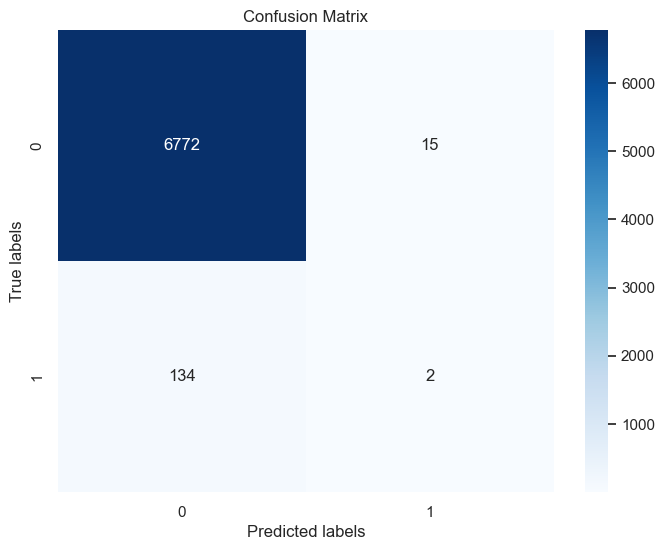

In [ ]:
 #Создание базовых моделей
model1 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model2 = AdaBoostClassifier(n_estimators=100, random_state=42)
model3 = XGBClassifier(n_estimators=100, random_state=42)
model4 = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
model5 = CatBoostClassifier(iterations=100, random_state=42, verbose=False)

# Создание объекта EnsembleVoteClassifier
ensemble = EnsembleVoteClassifier(clfs=[model1, model2, model3, model4, model5])
# Старт времени
start_time = time.time()
# Обучение модели ансамбля
ensemble.fit(X_train_smote, y_train_smote)

# Фиксация времени
fit_time = time.time() - start_time

print(f"Fit Time: {fit_time:.10f} seconds")

# Предсказание на тестовой выборке
y_pred = ensemble.predict(X_test_sc)

# Вывод отчета по метрикам классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Получение предсказанных вероятностей для каждого класса
y_ens =ensemble.predict_proba(X_test_sc)

# Предсказанные вероятности для класса 1
# Обычно класс 1 соответствует второму столбцу возвращаемого массива
y_ens_class_1 = y_ens[:, 1]


In [ ]:
# Расчет AUC-ROC
auc = roc_auc_score(y_test,y_ens_class_1)
print(f"AUC-ROC_1: {auc}")

AUC-ROC_1: 0.830923521611385


Fit Time: 231.6633729935 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6787
           1       0.04      0.08      0.06       136

    accuracy                           0.95      6923
   macro avg       0.51      0.52      0.51      6923
weighted avg       0.96      0.95      0.95      6923

Confusion Matrix:
[[6545  242]
 [ 125   11]]


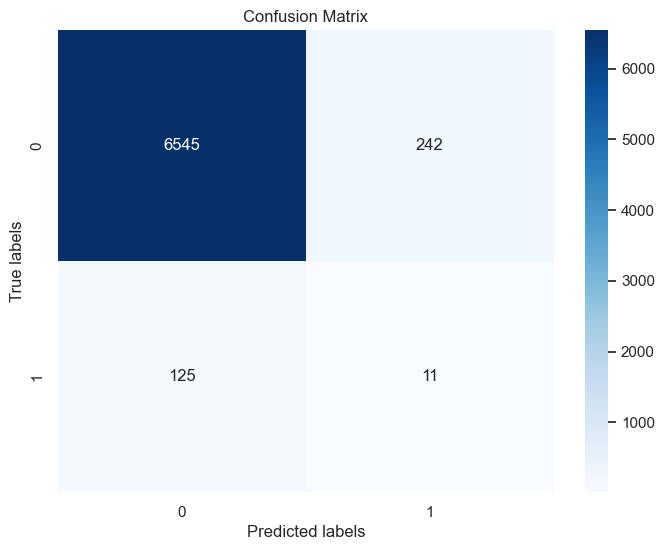

In [ ]:
# Создание базовых моделей
model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_2 = SVC(probability=True)
model_3 = DecisionTreeClassifier(random_state=42)
model_4 = KNeighborsClassifier()

# Создание объекта EnsembleVoteClassifier
ensemble_1 = EnsembleVoteClassifier(clfs=[model_1,model_2,model_3,model_4],voting='hard')  # 'hard' voting combines predictions by majority voting
# Старт времени
start_time = time.time()
# Обучение модели ансамбля
ensemble_1.fit(X_train_smote, y_train_smote)
# Фиксация времени
fit_time = time.time() - start_time
print(f"Fit Time: {fit_time:.10f} seconds")


# Предсказание на тестовой выборке
y_pred = ensemble_1.predict(X_test_sc)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
# Вывод отчета по метрикам классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок (вывод)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Получение предсказанных вероятностей для каждого класса
y_ens_1 =ensemble_1.predict_proba(X_test_sc)

# Предсказанные вероятности для класса 1
# Обычно класс 1 соответствует второму столбцу возвращаемого массива
y_ens_1_class_1 = y_ens_1[:, 1]



In [ ]:

# Расчет AUC-ROC
auc = roc_auc_score(y_test,y_ens_class_1)
print(f"AUC-ROC_1: {auc}")


AUC-ROC_1: 0.830923521611385


# Stacking: Random Oversampling

Fit Time: 270.2329320908 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6787
           1       0.05      0.01      0.02       136

    accuracy                           0.97      6923
   macro avg       0.51      0.50      0.50      6923
weighted avg       0.96      0.97      0.97      6923

Confusion Matrix:
[[6746   41]
 [ 134    2]]


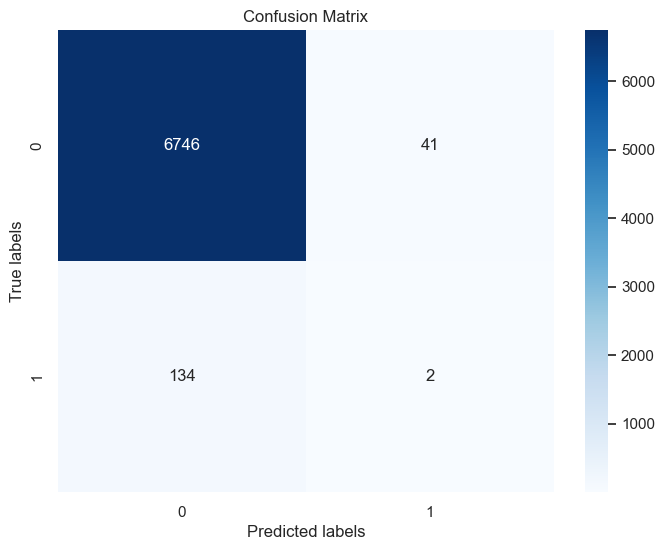

In [ ]:

model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
model_2 = SVC(probability=True)
model_3 = DecisionTreeClassifier(random_state=42)
model_4 = KNeighborsClassifier()

ensemble_2 = EnsembleVoteClassifier(clfs=[model_1,model_2,model_3,model_4],voting='hard')  # 'hard' voting combines predictions by majority voting

start_time = time.time()

ensemble_2.fit(X_train_over, y_train_over)

fit_time = time.time() - start_time
print(f"Fit Time: {fit_time:.10f} seconds")

y_pred = ensemble_2.predict(X_test_sc)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

y_ens_2 =ensemble_2.predict_proba(X_test_sc)

y_ens_2_class_1 = y_ens_2[:, 1]


In [ ]:

auc = roc_auc_score(y_test,y_ens_2_class_1)
print(f"AUC-ROC_1: {auc}")


AUC-ROC_1: 0.806302490054516


Fit Time: 5.8012692928 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      6787
           1       0.07      0.61      0.13       136

    accuracy                           0.84      6923
   macro avg       0.53      0.72      0.52      6923
weighted avg       0.97      0.84      0.89      6923

Confusion Matrix:
[[5699 1088]
 [  53   83]]


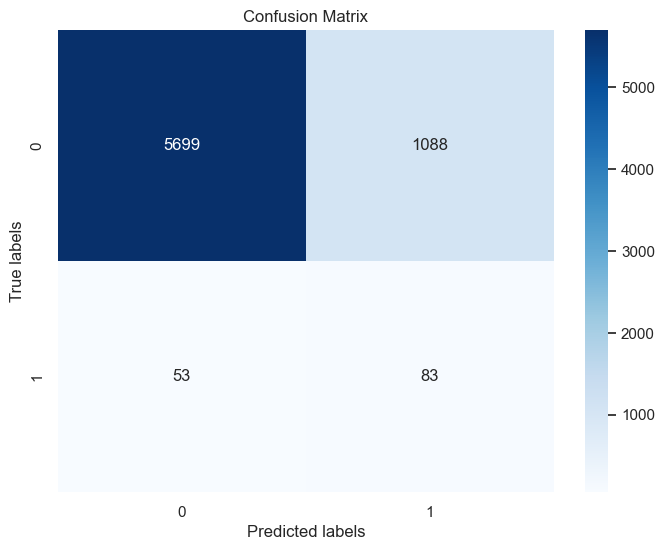

In [ ]:

model1 = GradientBoostingClassifier(n_estimators=100, random_state=42)
model2 = AdaBoostClassifier(n_estimators=100, random_state=42)
model3 = XGBClassifier(n_estimators=100, random_state=42)
model4 = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
model5 = CatBoostClassifier(iterations=100, random_state=42, verbose=False)

ensemble_3 = EnsembleVoteClassifier(clfs=[model1, model2, model3, model4, model5])

start_time = time.time()

ensemble_3.fit(X_train_over, y_train_over)

fit_time = time.time() - start_time
print(f"Fit Time: {fit_time:.10f} seconds")

y_pred = ensemble_3.predict(X_test_sc)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")

print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_ens_3 =ensemble_3.predict_proba(X_test_sc)

y_ens_3_class_1 = y_ens_3[:, 1]

auc = roc_auc_score(y_test,y_ens_3_class_1)
print(f"AUC-ROC_1: {auc}")


AUC-ROC_1: 0.8265585591832136


# Random Undersampling -  кросс-валидация

In [ ]:
list_of_models = [
        CatBoostClassifier(),#boosting
        AdaBoostClassifier(),#boosting
        XGBClassifier(),#boosting
        LGBMClassifier(),#boosting
        GradientBoostingClassifier()] #boosting

#Эта строка создает список имен моделей в list_of_models.
#Для каждой модели x в list_of_models она использует функцию type(x).__name__, которая возвращает строковое имя класса объекта.
#Например, если модель - CatBoostClassifier(), type(x).__name__ вернет строку 'CatBoostClassifier'.
list_of_model_names = [type(x).__name__ for x in list_of_models]

cv_results = pd.DataFrame(
        data=0.0,
        index=list_of_model_names,
        columns=['fit_time', 'score_time', 'accuracy', 'precision', 'recall', 'f1'])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

for model in list_of_models:
    cv_result = cross_validate(
        estimator=model,
        X=X_train_under,
        y=y_train_under,
        scoring=scoring,
        cv=10,
        n_jobs=-1)

    cv_results.loc[type(model).__name__] = list(map(np.mean, cv_result.values()))

cv_results

,fit_time,score_time,accuracy,precision,recall,f1
CatBoostClassifier,4.279443,0.008701,0.769901,0.777739,0.769745,0.768005
AdaBoostClassifier,0.091602,0.011600,0.740941,0.748827,0.740804,0.738507
XGBClassifier,0.172833,0.005000,0.734079,0.737689,0.733941,0.732914
LGBMClassifier,0.629500,0.006501,0.758950,0.763315,0.758843,0.757883
GradientBoostingClassifier,0.186103,0.004698,0.748970,0.756885,0.748804,0.746813


In [ ]:
base_classifiers = [
    RandomForestClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    KNeighborsClassifier()
]

list_of_model_names = [type(x).__name__ for x in base_classifiers]

cv_results = pd.DataFrame(
    data=0.0,
    index=list_of_model_names,
    columns=['fit_time', 'score_time', 'accuracy', 'precision', 'recall', 'f1']
)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

for model, model_name in zip(base_classifiers, list_of_model_names):
    bagging = BaggingClassifier(base_estimator=model)
    cv_result = cross_validate(
        estimator=bagging,
        X=X_train_under,
        y=y_train_under,
        scoring=scoring,
        cv=10,
        n_jobs=-1
    )

    cv_results.loc[model_name] = list(map(np.mean, cv_result.values()))

cv_results

,fit_time,score_time,accuracy,precision,recall,f1
RandomForestClassifier,1.992305,0.072500,0.772871,0.780865,0.772706,0.770889
SVC,0.114996,0.039606,0.766911,0.772646,0.766765,0.765536
DecisionTreeClassifier,0.045886,0.006421,0.734030,0.736487,0.733863,0.733037
KNeighborsClassifier,0.009271,0.205299,0.720050,0.723580,0.719882,0.718890
